In [1]:
# Computations
import numpy as np
import pandas as pd
import scipy.stats as stats

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV, KFold
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex, clear_output

## missingno
import missingno as msno

## plotly
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.express as px

## seaborn
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (17, 6)
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-info">
<font size="+3"><b>
Pima Indians Diabetes Dataset
</b></font>
</div>


In this article, we use [Kaggle's](kaggle.com)[Pima Indians Diabetes](https://www.kaggle.com/uciml/pima-indians-diabetes-database). The [Pima indians](https://en.wikipedia.org/wiki/Pima_people) are a group of Native Americans living in an area consisting of what is now central and southern Arizona. A variety of statistical methods are used here for predictions.

## Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Content
The datasets consist of several medical predictor variables and one target variable, **Outcome**. Predictor variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

# Dataset Analysis

In [2]:
Data = pd.read_csv('pima-indians-diabetes-database/diabetes_mod.csv')
display(Data.head())

display(pd.DataFrame({'Number of Instances': [Data.shape[0]], 'Number of Attributes': [Data.shape[1]]}).style.hide_index())

,Pregnancies,Glucose,Blood Pressure,Skin Thickness,Insulin,BMI,Diabetes Pedigree Function,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,0.254,33.0,1


Number of Instances,Number of Attributes
768,9


| Feature                  | Explanations                                                             |
|--------------------------|--------------------------------------------------------------------------|
| Pregnancies              | Number of times pregnant                                                 |
| Glucose                  | Plasma glucose concentration a 2 hours in an oral glucose tolerance test |
| Blood Pressure            | Diastolic blood pressure (mm Hg)                                         |
| Skin Thickness            | Triceps skinfold thickness (mm)                                          |
| Insulin                  | 2-Hour serum insulin (mu U/ml)                                           |
| BMI                      | Body mass index (weight in kg/(height in m)^2)                           |
| Diabetes Pedigree Function | Diabetes pedigree function                                               |
| Age                      | Age (years)                                                              |
| Outcome                  | Whether or not a patient has diabetes                                    |

# Modeling: Feature Importance


In this article, we use **RFE** from the [**sklearn.feature_selection**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) which provides feature ranking with recursive feature elimination. The classifiers that we use throughout this article are listed in the following table.

| Classifier               | Link                                                                                                                                      |
|--------------------------|-------------------------------------------------------------------------------------------------------------------------------------------|
| Decision Tree Classifier | [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)         |
| Random Forest Classifier | [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) |


Splitting the data into X and y sets:

In [3]:
Target = 'Outcome'
X = Data.drop(columns = [Target])
y = Data[Target]
Labels = ['Non-Diabetic', 'Diabetic']

## Variance of the Features

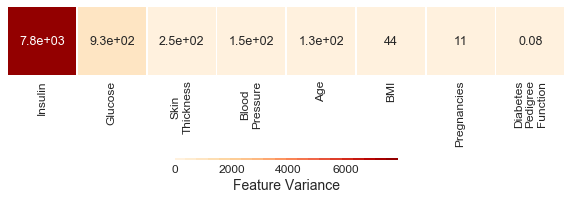

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
Temp = X.var().sort_values(ascending = False).to_frame(name= 'Variance').round(2).T
_ = sns.heatmap(Temp, ax=ax, annot=True, square=True,  cmap =sns.color_palette("OrRd", 20),
                  linewidths = 0.8, vmin=0, vmax=Temp.max(axis =1)[0],  annot_kws={"size": 12.5},
                  cbar_kws={'label': 'Feature Variance', "aspect":80, "shrink": .4, "orientation": "horizontal"})
lb = [x.replace(' ','\n').replace('\nof\n',' of\n') for x in [item.get_text() for item in ax.get_xticklabels()]]
_ = ax.set_xticklabels(lb)
_ = ax.set_yticklabels('')
del Temp

We can standardize features by removing the mean and scaling to unit variance.

In [5]:
scaler = StandardScaler()
Temp = scaler.fit_transform(X)
X = pd.DataFrame(data = Temp, columns = X.columns)
del Temp

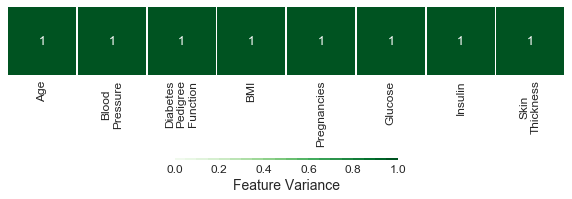

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
Temp = X.var().sort_values(ascending = False).to_frame(name= 'Variance').round(2).T
_ = sns.heatmap(Temp, ax=ax, annot=True, square=True,  cmap =sns.color_palette("Greens", 20),
                  linewidths = 0.8, vmin=0, vmax=Temp.max(axis =1)[0],  annot_kws={"size": 12.5},
                  cbar_kws={'label': 'Feature Variance', "aspect":80, "shrink": .4, "orientation": "horizontal"})
lb = [x.replace(' ','\n').replace('\nof\n',' of\n') for x in [item.get_text() for item in ax.get_xticklabels()]]
_ = ax.set_xticklabels(lb)
_ = ax.set_yticklabels('')
del Temp

## Train and Test Sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
               'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

Set,X_train,X_test,y_train,y_test
Shape,"(537, 8)","(231, 8)","(537,)","(231,)"


A number of functions that we will be using throughout this article:

In [8]:
def ScoreTable(cls, Name, X = X, y = y):
    score = cross_validate(cls, X, y, scoring=['f1_weighted', 'recall',
                                               'roc_auc'], return_train_score = True, n_jobs=-1, verbose=0)
    Scores = pd.DataFrame(score).mean(axis = 0).map(lambda x: ('%.2f' % x)) + ' ± ' + \
            pd.DataFrame(score).std(axis = 0).map(lambda x: ('%.2e' % x))
    Scores = Scores.to_frame(Name)
    Temp = [x.replace('_',' ').title().replace('Train','Train:').replace('Test','Test:').replace('Neg','')\
            for x in Scores.index]
    Scores.index = Temp
    return Scores

def Feature_Ranking(clf):
    df = pd.DataFrame()
    for n in range(2, X.shape[1]):
        selector = RFE(estimator= clf, n_features_to_select=n, verbose=0)
        selector.fit(X_train, y_train)
        df = df.append({'Number of Features to Select': n,
                        'Score':metrics.accuracy_score(y_test, selector.predict(X_test)),
                        'Features': X.columns[selector.support_].tolist(),
                        'Best Features':X.columns[selector.ranking_ == 1].tolist()}, ignore_index=True)
        df['Number of Features to Select'] = df['Number of Features to Select'].astype(int)

    df = df[['Number of Features to Select', 'Score', 'Features', 'Best Features']]
    return df, df.loc[df.Score == df.Score.max(), 'Features'].values[0]    

def ROC_Plot(y_test, Proba, pad = 1e-2, FS = 6):
    # false positive rates, true positive rates and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_test, Proba)
    fig, ax = plt.subplots(1, 1, figsize=(FS, FS))
    _ = ax.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % metrics.auc(fpr, tpr))
    _ = ax.plot([0, 1], [0, 1],'r--', lw=2)
    _ = ax.legend(loc = 'lower right', fontsize = 14)
    _ = ax.set_xlim([0-pad,1+pad])
    _ = ax.set_ylim([0-pad,1+pad])
    _ = ax.set_xlabel('False Positive Rate (FPR)')
    _ = ax.set_ylabel('True Positive Rate (TPR)')
    _ = ax.set_title('Receiver Operating Characteristic (ROC)', fontsize =16)
    _ = ax.set(aspect='equal')
    
def Confusion_Matrix(grid, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    # Font
    font = FontProperties()
    font.set_weight('bold')
    
    # Train
    y_pred = grid.predict(X_train)
    CM = metrics.confusion_matrix(y_train, y_pred)
    Results = pd.DataFrame(metrics.classification_report(y_train, y_pred, target_names=Labels, output_dict=True)).T
    Results.index.name = 'Train Set'
    display(Results.round(4))

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Train Set', fontproperties=font, fontsize = 18)
    _ = sns.heatmap(CM, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
                    linewidths = 0.2, cbar_kws={"shrink": 1})
    _ = ax[0].set_title('Confusion Matrix');

    CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
    _ = sns.heatmap(CM, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
                   linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
    _ = ax[1].set_title('Normalized Confusion Matrix');
    
    for a in ax:
        _ = a.set_xlabel('Predicted labels')
        _ = a.set_ylabel('True labels'); 
        _ = a.xaxis.set_ticklabels(Labels)
        _ = a.yaxis.set_ticklabels(Labels)
        _ = a.set(aspect='equal')
        
    # Test
    y_pred = grid.predict(X_test)
    CM = metrics.confusion_matrix(y_test, y_pred)
    Results = pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names=Labels, output_dict=True)).T
    Results.index.name = 'Test Set'
    display(Results.round(4))

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Test Set', fontproperties=font, fontsize = 18)
    _ = sns.heatmap(CM, annot=True, annot_kws={"size": 14}, cmap="Blues", ax = ax[0],
                    linewidths = 0.2, cbar_kws={"shrink": 1})
    _ = ax[0].set_title('Confusion Matrix');

    CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
    _ = sns.heatmap(CM, annot=True, annot_kws={"size": 14}, cmap="Greens", ax = ax[1],
                   linewidths = 0.2, vmin=0, vmax=1, cbar_kws={"shrink": 1})
    _ = ax[1].set_title('Normalized Confusion Matrix');
    
    for a in ax:
        _ = a.set_xlabel('Predicted labels')
        _ = a.set_ylabel('True labels'); 
        _ = a.xaxis.set_ticklabels(Labels)
        _ = a.yaxis.set_ticklabels(Labels)
        _ = a.set(aspect='equal')

# Decision Tree Classifier (DTC)

In [9]:
dtc = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
Table = ScoreTable(dtc, 'DTC', X = X, y = y)
display(Table)

,DTC
Fit Time,0.00 ± 4.47e-04
Score Time,0.00 ± 4.47e-04
Test: F1 Weighted,0.70 ± 3.06e-02
Train: F1 Weighted,0.78 ± 2.44e-02
Test: Recall,0.49 ± 1.33e-01
Train: Recall,0.61 ± 1.70e-01
Test: Roc Auc,0.78 ± 4.93e-02
Train: Roc Auc,0.87 ± 8.36e-03


Classification Performance:

,precision,recall,f1-score,support
Train Set,,,,
Non-Diabetic,0.8893,0.7822,0.8323,349.0000
Diabetic,0.6696,0.8191,0.7368,188.0000
accuracy,0.7952,0.7952,0.7952,0.7952
macro avg,0.7794,0.8007,0.7846,537.0000
weighted avg,0.8123,0.7952,0.7989,537.0000


,precision,recall,f1-score,support
Test Set,,,,
Non-Diabetic,0.8525,0.6887,0.7619,151.0000
Diabetic,0.5688,0.7750,0.6561,80.0000
accuracy,0.7186,0.7186,0.7186,0.7186
macro avg,0.7106,0.7319,0.7090,231.0000
weighted avg,0.7542,0.7186,0.7253,231.0000


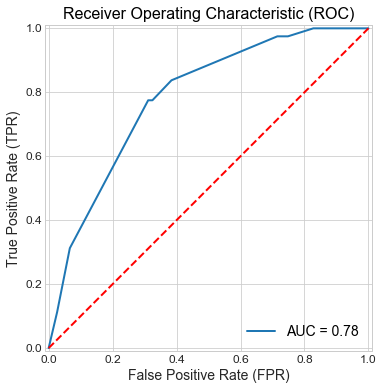

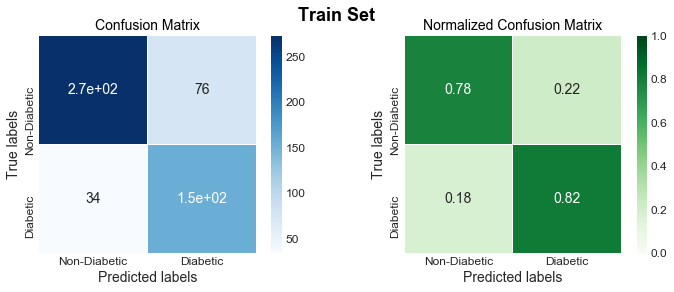

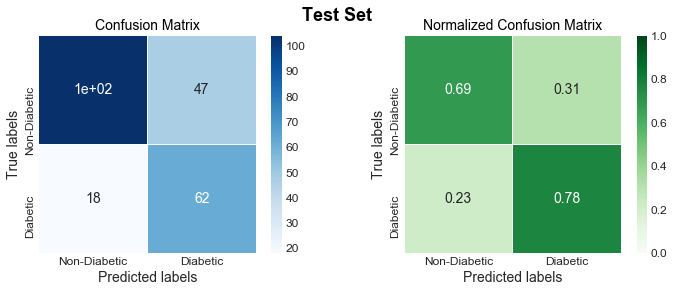

In [10]:
_ = dtc.fit(X_train,y_train)
ROC_Plot(y_test, dtc.predict_proba(X_test)[:,1])
Confusion_Matrix(dtc)

## Feature Ranking

In [11]:
Rank_Table, Best_Features = Feature_Ranking(dtc)
display(Rank_Table.style.hide_index().set_precision(4).background_gradient(subset= ['Score'], cmap='Greens'))

Number of Features to Select,Score,Features,Best Features
2,0.7186,"['Glucose', 'BMI']","['Glucose', 'BMI']"
3,0.7186,"['Glucose', 'BMI', 'Age']","['Glucose', 'BMI', 'Age']"
4,0.7143,"['Glucose', 'BMI', 'Diabetes Pedigree Function', 'Age']","['Glucose', 'BMI', 'Diabetes Pedigree Function', 'Age']"
5,0.7143,"['Glucose', 'Insulin', 'BMI', 'Diabetes Pedigree Function', 'Age']","['Glucose', 'Insulin', 'BMI', 'Diabetes Pedigree Function', 'Age']"
6,0.7143,"['Pregnancies', 'Glucose', 'Skin Thickness', 'BMI', 'Diabetes Pedigree Function', 'Age']","['Pregnancies', 'Glucose', 'Skin Thickness', 'BMI', 'Diabetes Pedigree Function', 'Age']"
7,0.7186,"['Pregnancies', 'Glucose', 'Skin Thickness', 'Insulin', 'BMI', 'Diabetes Pedigree Function', 'Age']","['Pregnancies', 'Glucose', 'Skin Thickness', 'Insulin', 'BMI', 'Diabetes Pedigree Function', 'Age']"


## Decision Tree Classifier (DTC) with the Best Features

In [12]:
dtc = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
Temp = ScoreTable(dtc, 'DTC with the Best Features', X = X[Best_Features], y = y)
Table = pd.concat([Table, Temp], axis = 1)
del Temp
display(Table)

,DTC,DTC with the Best Features
Fit Time,0.00 ± 4.47e-04,0.00 ± 5.48e-04
Score Time,0.00 ± 4.47e-04,0.00 ± 4.47e-04
Test: F1 Weighted,0.70 ± 3.06e-02,0.73 ± 1.52e-02
Train: F1 Weighted,0.78 ± 2.44e-02,0.77 ± 2.26e-02
Test: Recall,0.49 ± 1.33e-01,0.49 ± 6.65e-02
Train: Recall,0.61 ± 1.70e-01,0.55 ± 1.09e-01
Test: Roc Auc,0.78 ± 4.93e-02,0.78 ± 5.54e-02
Train: Roc Auc,0.87 ± 8.36e-03,0.85 ± 1.24e-02


Classification Performance:

,precision,recall,f1-score,support
Train Set,,,,
Non-Diabetic,0.7446,0.9857,0.8483,349.0000
Diabetic,0.9333,0.3723,0.5323,188.0000
accuracy,0.7709,0.7709,0.7709,0.7709
macro avg,0.8390,0.6790,0.6903,537.0000
weighted avg,0.8107,0.7709,0.7377,537.0000


,precision,recall,f1-score,support
Test Set,,,,
Non-Diabetic,0.7172,0.9404,0.8138,151.0000
Diabetic,0.7273,0.3000,0.4248,80.0000
accuracy,0.7186,0.7186,0.7186,0.7186
macro avg,0.7222,0.6202,0.6193,231.0000
weighted avg,0.7207,0.7186,0.6790,231.0000


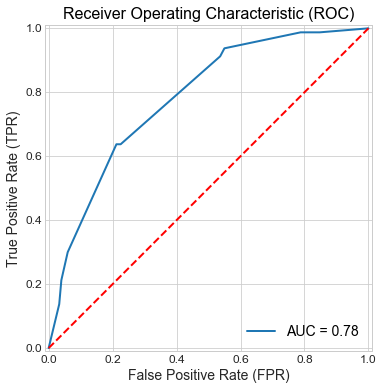

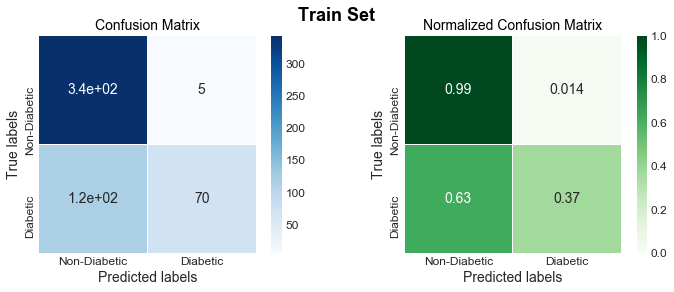

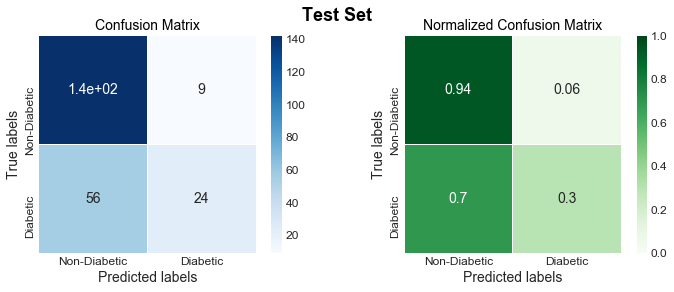

In [13]:
_ = dtc.fit(X_train[Best_Features],y_train)
ROC_Plot(y_test, dtc.predict_proba(X_test[Best_Features])[:,1])
Confusion_Matrix(dtc, X_train = X_train[Best_Features], X_test = X_test[Best_Features])

# Random Forest Classifier (RFC)

In [14]:
rfc = RandomForestClassifier()
Temp = ScoreTable(rfc, 'RFC', X = X, y = y)
Table = pd.concat([Table, Temp], axis = 1)
del Temp
display(Table)

,DTC,DTC with the Best Features,RFC
Fit Time,0.00 ± 4.47e-04,0.00 ± 5.48e-04,0.12 ± 8.95e-04
Score Time,0.00 ± 4.47e-04,0.00 ± 4.47e-04,0.02 ± 8.37e-04
Test: F1 Weighted,0.70 ± 3.06e-02,0.73 ± 1.52e-02,0.76 ± 4.30e-02
Train: F1 Weighted,0.78 ± 2.44e-02,0.77 ± 2.26e-02,1.00 ± 0.00e+00
Test: Recall,0.49 ± 1.33e-01,0.49 ± 6.65e-02,0.59 ± 8.66e-02
Train: Recall,0.61 ± 1.70e-01,0.55 ± 1.09e-01,1.00 ± 0.00e+00
Test: Roc Auc,0.78 ± 4.93e-02,0.78 ± 5.54e-02,0.82 ± 3.73e-02
Train: Roc Auc,0.87 ± 8.36e-03,0.85 ± 1.24e-02,1.00 ± 0.00e+00


Classification Performance:

,precision,recall,f1-score,support
Train Set,,,,
Non-Diabetic,1.0,1.0,1.0,349.0
Diabetic,1.0,1.0,1.0,188.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,537.0
weighted avg,1.0,1.0,1.0,537.0


,precision,recall,f1-score,support
Test Set,,,,
Non-Diabetic,0.8026,0.8079,0.8053,151.0000
Diabetic,0.6329,0.6250,0.6289,80.0000
accuracy,0.7446,0.7446,0.7446,0.7446
macro avg,0.7178,0.7165,0.7171,231.0000
weighted avg,0.7439,0.7446,0.7442,231.0000


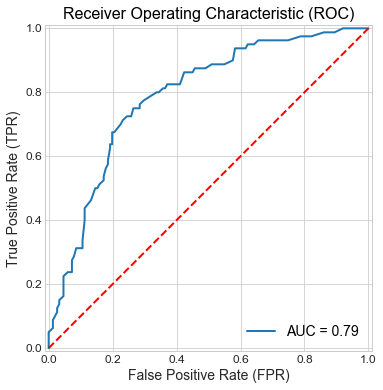

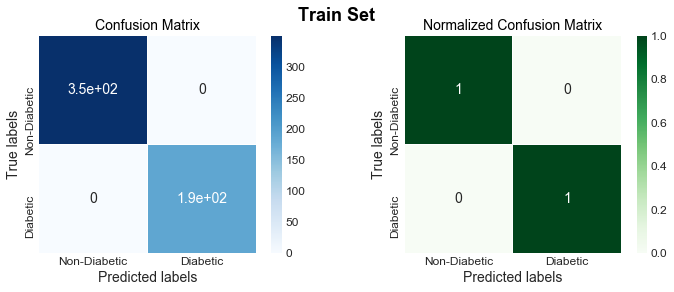

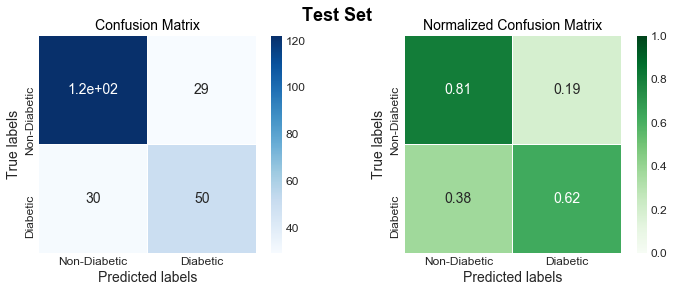

In [15]:
_ = rfc.fit(X_train, y_train)
ROC_Plot(y_test, rfc.predict_proba(X_test)[:,1])
Confusion_Matrix(rfc)

## Feature Ranking

In [16]:
Rank_Table, Best_Features = Feature_Ranking(rfc)
display(Rank_Table.style.hide_index().set_precision(4).background_gradient(subset= ['Score'], cmap='Greens'))

Number of Features to Select,Score,Features,Best Features
2,0.7229,"['Glucose', 'BMI']","['Glucose', 'BMI']"
3,0.7100,"['Glucose', 'BMI', 'Age']","['Glucose', 'BMI', 'Age']"
4,0.7273,"['Glucose', 'BMI', 'Diabetes Pedigree Function', 'Age']","['Glucose', 'BMI', 'Diabetes Pedigree Function', 'Age']"
5,0.7489,"['Glucose', 'Blood Pressure', 'BMI', 'Diabetes Pedigree Function', 'Age']","['Glucose', 'Blood Pressure', 'BMI', 'Diabetes Pedigree Function', 'Age']"
6,0.7446,"['Pregnancies', 'Glucose', 'Blood Pressure', 'BMI', 'Diabetes Pedigree Function', 'Age']","['Pregnancies', 'Glucose', 'Blood Pressure', 'BMI', 'Diabetes Pedigree Function', 'Age']"
7,0.7316,"['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'BMI', 'Diabetes Pedigree Function', 'Age']","['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'BMI', 'Diabetes Pedigree Function', 'Age']"


## Random Forest Classifier (RFC) with the Best Features

In [17]:
rfc = RandomForestClassifier()
Temp = ScoreTable(rfc, 'RFC with the Best Features', X = X[Best_Features], y = y)
Table = pd.concat([Table, Temp], axis = 1)
display(Table)

,DTC,DTC with the Best Features,RFC,RFC with the Best Features
Fit Time,0.00 ± 4.47e-04,0.00 ± 5.48e-04,0.12 ± 8.95e-04,0.12 ± 1.30e-03
Score Time,0.00 ± 4.47e-04,0.00 ± 4.47e-04,0.02 ± 8.37e-04,0.02 ± 4.48e-04
Test: F1 Weighted,0.70 ± 3.06e-02,0.73 ± 1.52e-02,0.76 ± 4.30e-02,0.76 ± 5.32e-02
Train: F1 Weighted,0.78 ± 2.44e-02,0.77 ± 2.26e-02,1.00 ± 0.00e+00,1.00 ± 0.00e+00
Test: Recall,0.49 ± 1.33e-01,0.49 ± 6.65e-02,0.59 ± 8.66e-02,0.62 ± 8.00e-02
Train: Recall,0.61 ± 1.70e-01,0.55 ± 1.09e-01,1.00 ± 0.00e+00,1.00 ± 0.00e+00
Test: Roc Auc,0.78 ± 4.93e-02,0.78 ± 5.54e-02,0.82 ± 3.73e-02,0.82 ± 4.15e-02
Train: Roc Auc,0.87 ± 8.36e-03,0.85 ± 1.24e-02,1.00 ± 0.00e+00,1.00 ± 0.00e+00


Classification Performance:

,precision,recall,f1-score,support
Train Set,,,,
Non-Diabetic,1.0,1.0,1.0,349.0
Diabetic,1.0,1.0,1.0,188.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,537.0
weighted avg,1.0,1.0,1.0,537.0


,precision,recall,f1-score,support
Test Set,,,,
Non-Diabetic,0.8079,0.8079,0.8079,151.0000
Diabetic,0.6375,0.6375,0.6375,80.0000
accuracy,0.7489,0.7489,0.7489,0.7489
macro avg,0.7227,0.7227,0.7227,231.0000
weighted avg,0.7489,0.7489,0.7489,231.0000


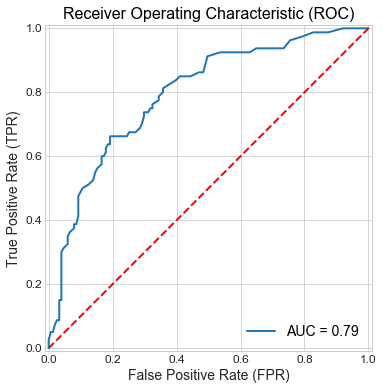

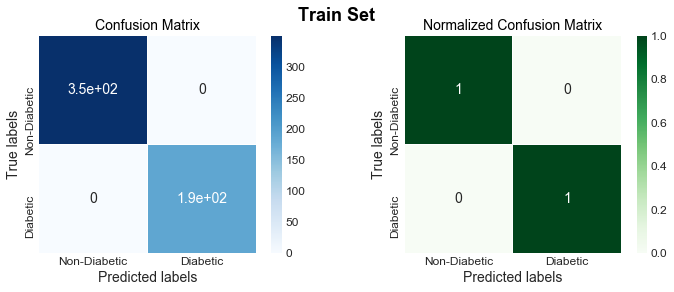

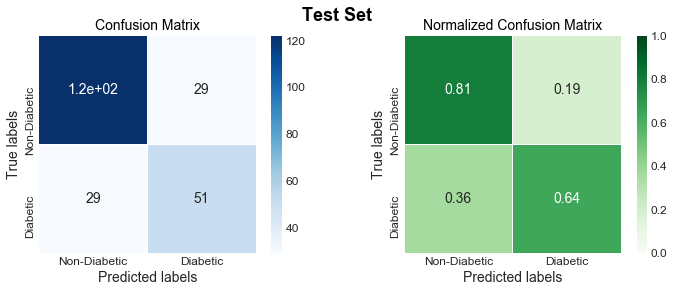

In [18]:
_ = rfc.fit(X_train[Best_Features],y_train)
ROC_Plot(y_test, rfc.predict_proba(X_test[Best_Features])[:,1])
Confusion_Matrix(rfc, X_train = X_train[Best_Features], X_test = X_test[Best_Features])

# Conclusion

Let'ts look at the performance table.

In [19]:
display(Table)

,DTC,DTC with the Best Features,RFC,RFC with the Best Features
Fit Time,0.00 ± 4.47e-04,0.00 ± 5.48e-04,0.12 ± 8.95e-04,0.12 ± 1.30e-03
Score Time,0.00 ± 4.47e-04,0.00 ± 4.47e-04,0.02 ± 8.37e-04,0.02 ± 4.48e-04
Test: F1 Weighted,0.70 ± 3.06e-02,0.73 ± 1.52e-02,0.76 ± 4.30e-02,0.76 ± 5.32e-02
Train: F1 Weighted,0.78 ± 2.44e-02,0.77 ± 2.26e-02,1.00 ± 0.00e+00,1.00 ± 0.00e+00
Test: Recall,0.49 ± 1.33e-01,0.49 ± 6.65e-02,0.59 ± 8.66e-02,0.62 ± 8.00e-02
Train: Recall,0.61 ± 1.70e-01,0.55 ± 1.09e-01,1.00 ± 0.00e+00,1.00 ± 0.00e+00
Test: Roc Auc,0.78 ± 4.93e-02,0.78 ± 5.54e-02,0.82 ± 3.73e-02,0.82 ± 4.15e-02
Train: Roc Auc,0.87 ± 8.36e-03,0.85 ± 1.24e-02,1.00 ± 0.00e+00,1.00 ± 0.00e+00


We can see that in this example, the Random Forest Classification using the important features have performed the best.

***
# References

1. [Smith, J. W., Everhart, J. E., Dickson, W. C., Knowler, W. C., & Johannes, R. S. (1988). Using the ADAP Learning Algorithm to Forecast the Onset of Diabetes Mellitus. Proceedings of the Annual Symposium on Computer Application in Medical Care, 261–265.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/)
***